Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3810 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.3805 - val_loss: 0.3800 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.3801 - val_loss: 0.3796 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.3796 - val_loss: 0.3791 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.3791 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.3786 - val_loss: 0.3786 - learning_rate: 1.0000e-04
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.3785 - val_loss: 0.3785 - learning_rate: 1.0000e-04
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.3785 - val_loss: 0.3785 - learning_rate: 1.0000e-04
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.3784 - val_loss: 0.3784 - learning_rate: 1.0000e-04
Epoch 10/20
1/1

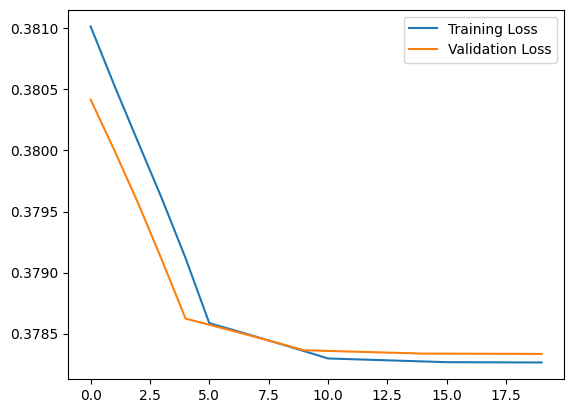

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


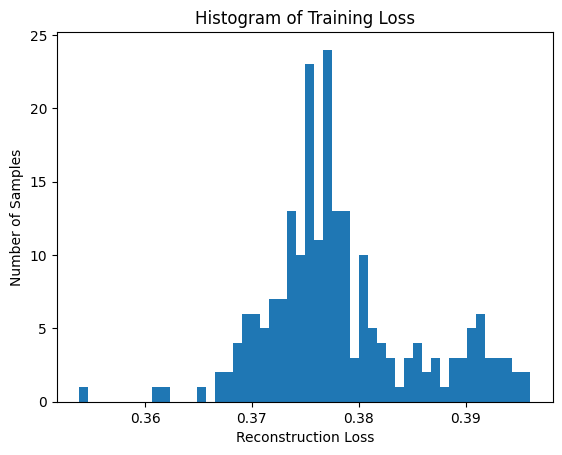

Threshold:  0.38539517
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.3269506941120153
Precision: 0.1956124314442413
Recall: 0.7886977886977887
F1 Score: 0.3134765625


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt

# Load datasets
dataframe_train = pd.read_csv('BATADAL_dataset04.csv')
dataframe_test = pd.read_csv('BATADAL_test_dataset.csv')

# Replace -999 with 0 in the datasets
dataframe_train.replace(-999, 0, inplace=True)
dataframe_test.replace(-999, 0, inplace=True)

# Preprocess training data
train_data = dataframe_train.drop(dataframe_train.columns[[0, -1]], axis=1)  # Remove date and label columns
train_labels = dataframe_train.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Preprocess testing data
testing_data = dataframe_test.drop(dataframe_test.columns[[0, -1]], axis=1)  # Remove date and label columns
testing_labels = dataframe_test.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Normalize data using training dataset stats
min_val = train_data.min().min()
max_val = train_data.max().max()

train_data = (train_data - min_val) / (max_val - min_val)
testing_data = (testing_data - min_val) / (max_val - min_val)

# Convert data to TensorFlow tensors
train_data = tf.cast(train_data, tf.float32)
testing_data = tf.cast(testing_data, tf.float32)

# Split normal and anomalous data
normal_train_data = train_data.numpy()[train_labels.to_numpy()]
normal_testing_data = testing_data.numpy()[testing_labels.to_numpy()]
anomalous_train_data = train_data.numpy()[~train_labels.to_numpy()]
anomalous_testing_data = testing_data.numpy()[~testing_labels.to_numpy()]

# Define an autoencoder model
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(16, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(train_data.shape[1], activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate and compile the model
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder on normal data
history = autoencoder.fit(
    normal_train_data, normal_train_data,
    epochs=20,
    batch_size=512,
    validation_data=(normal_testing_data, normal_testing_data),
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler_callback]
)

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Calculate reconstruction loss on normal train data
train_reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(train_reconstructions, normal_train_data)

# Plot histogram of train loss
plt.hist(train_loss.numpy(), bins=50)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Samples")
plt.title("Histogram of Training Loss")
plt.show()

# Set threshold for anomaly detection
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

# Define a prediction function
def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(data, reconstructions)
    return loss < threshold

# Make predictions on the entire test dataset
test_predictions = predict(autoencoder, testing_data, threshold)

# Convert predictions to binary (0 = anomalous, 1 = normal)
test_predictions = test_predictions.numpy().astype(int)

# Evaluate metrics
def print_stats(predictions, labels):
    print("Accuracy:", accuracy_score(labels, predictions))
    print("Precision:", precision_score(labels, predictions))
    print("Recall:", recall_score(labels, predictions))
    print("F1 Score:", f1_score(labels, predictions))

# Print the evaluation metrics
print_stats(test_predictions, testing_labels.astype(int))